# Tutorial
First, we need to import all the necessary modules.

In [1]:
%load_ext autoreload
%autoreload 2

# built-in libraries
import os 

# third party libraries
import matplotlib.pyplot as plt 
import numpy as np
import tqdm
import torch 
import torch.nn.functional as func

# repository modules
import models
import train
import adversarial.carlini_wagner as cw
import adversarial.pgd as pgd
import dataset
import utils

The training and test data is loaded in memory using the `dataset` local module. Before using the FAUST dataset download it from [here](http://faust.is.tue.mpg.de/) and place it in `{repository-root}/datasets/faust/raw/`.

In [2]:
REPO_ROOT = os.path.join(os.path.dirname(os.path.realpath('__file__')),"..")
FAUST = os.path.join(REPO_ROOT,"datasets/faust")
PARAMS_FILE = os.path.join(REPO_ROOT, "model_data/data.pt")

traindata = dataset.FaustDataset(FAUST, train=True, test=False, transform_data=True)
testdata = dataset.FaustDataset(FAUST, train=False, test=True,  transform_data=True)

C:\Users\giorg\Anaconda3\envs\adex\lib\site-packages\torch_geometric\data\dataset.py:94: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you really want to make use of another pre-processing technique, make sure to delete `C:\Users\giorg\Adversarial-Examples-on-Meshes\datasets\faust\processed/processed` first.
  self.processed_dir))


Then we can define the classifier for the human pose classefication task; download the classifier parameters from [here](https://drive.google.com/open?id=1IllCPPPcqFL3v8BDxCyswzEpxoGyXvMe). Move these parameters in `{repository-root}/model_data/data.pt` .

In [3]:
model = models.ChebnetClassifier(
    param_conv_layers=[128,128,64,64],
    D_t = traindata.downscale_matrices,
    E_t = traindata.downscaled_edges,
    num_classes = traindata.num_classes,
    parameters_file=PARAMS_FILE)

Training and evaluation can be done through the `train` local module.

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]

tensor(1.)


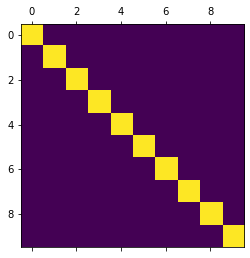

In [5]:
#train network
train.train(
    train_data=traindata,
    classifier=model,
    parameters_file=PARAMS_FILE,
    epoch_number=0)

#compute accuracy
accuracy, confusion_matrix = train.evaluate(eval_data=testdata, classifier=model)

print(accuracy)
plt.matshow(confusion_matrix)
plt.show()

### Carlini & Wagner Method
It is possible to create adversarial examples through the **AdversarialExampleBuilder** and **AdversarialExample** classes  

In [14]:
# get a random mesh from the dataset and a random target class
import random
i = random.randint(0, len(traindata)-1)
x = traindata[i].pos
e = traindata[i].edge_index.t() # needs to be transposed
f = traindata[i].face.t() # needs to be transposed
y = traindata[i].y
t = random.randint(0, traindata.num_classes-1)
eigs_num = 10

# configure adversarial example components
builder = cw.CWBuilder()
builder.set_classifier(model)
builder.set_perturbation_type("spectral", eigs_num=eigs_num)
builder.set_mesh(x, e, f)
builder.set_target(t)
builder.set_distortion_function(cw.L2_distortion)
builder.set_adversarial_coeff(0.0001)
builder.set_minimization_iterations(100).set_learning_rate(1e-4)
adex = builder.build(usetqdm="standard")
print("adversarial attack: "+("successful" if adex.is_successful else "unsuccessful"))

[0,0.0001] ; c=0.0001



adversarial attack: unsuccessful


We can finally see the actual adversarial example using **Plotly** (note: you need to install plotly before-hand)

In [6]:
import plotly
import plotly.graph_objects as go
import numpy as np

def visualize(pos, faces, intensity=None):
  cpu = torch.device("cpu")
  if type(pos) != np.ndarray:
    pos = pos.to(cpu).clone().detach().numpy()
  if pos.shape[-1] != 3:
    raise ValueError("Vertices positions must have shape [n,3]")
  if type(faces) != np.ndarray:
    faces = faces.to(cpu).clone().detach().numpy()
  if faces.shape[-1] != 3:
    raise ValueError("Face indices must have shape [m,3]") 
  if intensity is None:
    intensity = np.ones([pos.shape[0]])
  elif type(intensity) != np.ndarray:
    intensity = intensity.to(cpu).clone().detach().numpy()

  x, z, y = pos.T
  i, j, k = faces.T

  mesh = go.Mesh3d(x=x, y=y, z=z,
            color='lightpink',
            intensity=intensity,
            opacity=1,
            colorscale=[[0, 'gold'],[0.5, 'mediumturquoise'],[1, 'magenta']],
            i=i, j=j, k=k,
            showscale=True)
  layout = go.Layout(scene=go.layout.Scene(aspectmode="data")) 

  #pio.renderers.default="plotly_mimetype"
  fig = go.Figure(data=[mesh],
                  layout=layout)
  fig.update_layout(
      autosize=True,
      margin=dict(l=20, r=20, t=20, b=20),
      paper_bgcolor="LightSteelBlue")
  fig.show()

### Projected Gradient Descent Method

In [45]:
import random

import adversarial.pgd as pgd

i = random.randint(0, len(traindata)-1)
x = traindata[i].pos
e = traindata[i].edge_index.t() # needs to be transposed
f = traindata[i].face.t() # needs to be transposed
y = traindata[i].y
N=20

if model(x).argmax() == y:
    builder = pgd.PGDBuilder().set_iterations(1).set_epsilon(0.005).set_alpha(0.005).set_eigs_number(100).set_projection(pgd.lowband_filter)
    #builder = pgd.FGSMBuilder().set_epsilon(0.01)
    builder.set_mesh(x,e,f).set_classifier(model)
    adex = builder.build(usetqdm="standard")
    print("successful: {}".format(adex.is_successful))
    print("adversarial example's prediction: {}".format(model(adex.perturbed_pos).argmax()))
    print("ground-truth: {}".format(model(adex.pos).argmax()))
    #visualize(adex.perturbed_pos, f, (x-adex.perturbed_pos).norm(p=2,dim=-1))

    n = x.shape[0]
    tmpx = torch.cat([x, adex.perturbed_pos],dim=0)
    tmpf = torch.cat([f, f+n], dim=0)
    color = torch.zeros([n*2],dtype=x.dtype, device=x.device)
    color[n:] = (x-adex.perturbed_pos).norm(p=2,dim=-1)
    visualize(tmpx, tmpf,color)
else:
    print("Oh no!")

successful: True
adversarial example's prediction: 5
ground-truth: 0


In [40]:
(adex.perturbed_pos -adex.pos).abs().max()

tensor(0.0098)

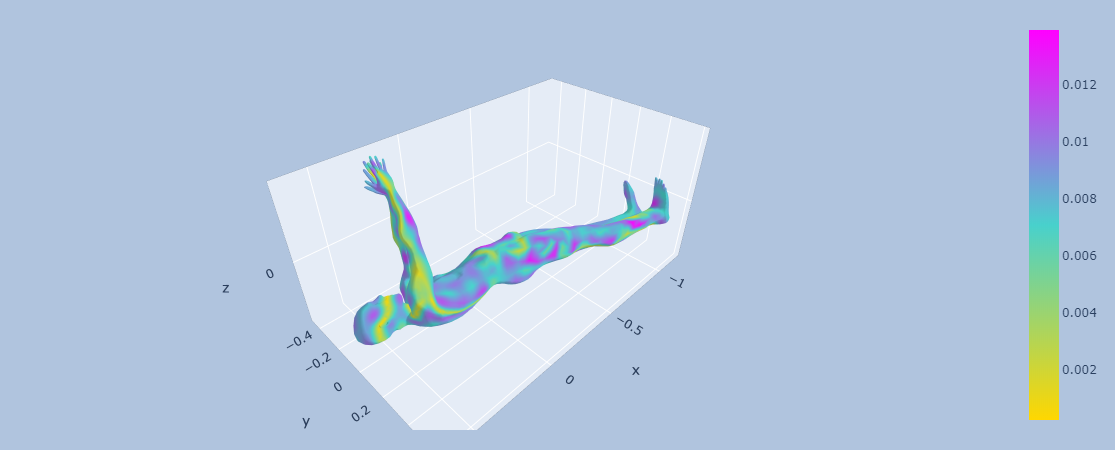

In [41]:
visualize(tmpx[n:], f, color[n:])